<a href="https://colab.research.google.com/github/Rishabh4821/Particle-Swarm-Optimization/blob/main/robot_path_planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

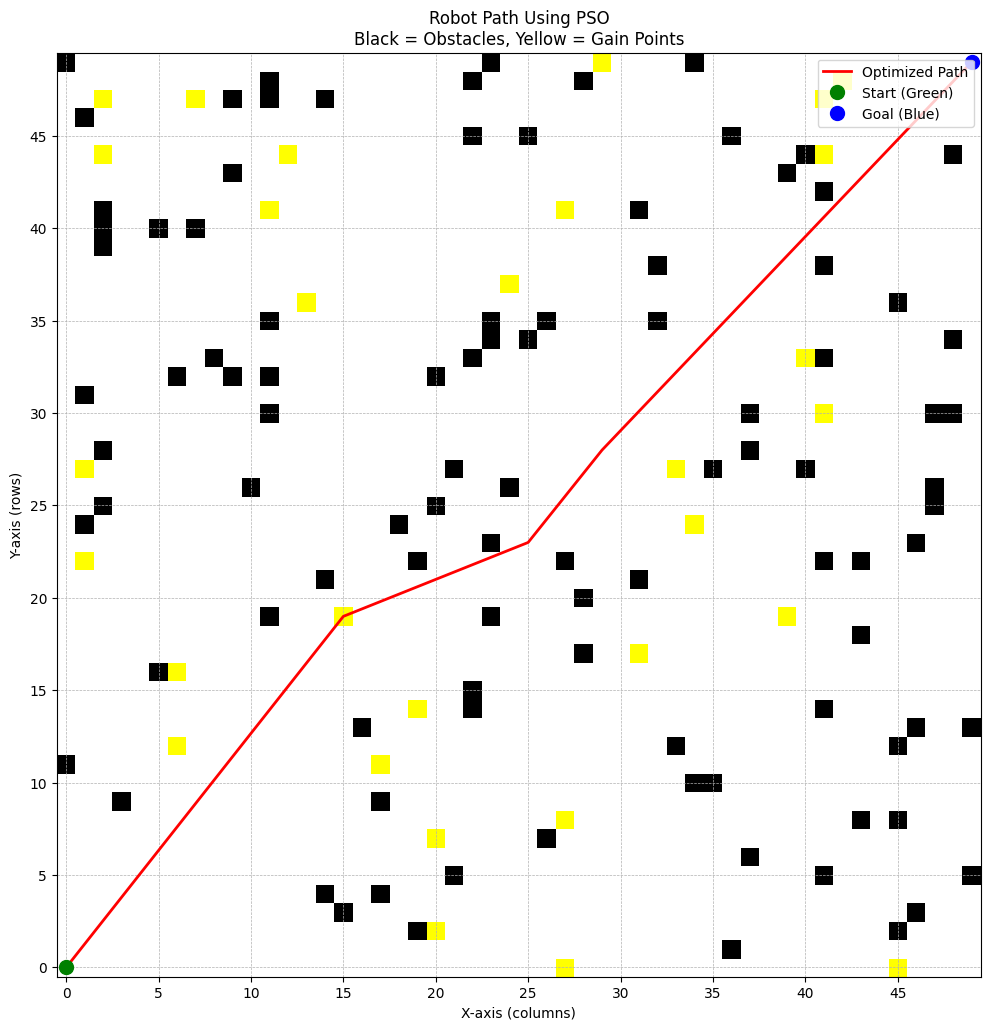

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

# ==== PARAMETERS ====
GRID_SIZE = 50
NUM_OBSTACLES = 100
NUM_GAIN_POINTS = 30
NUM_PARTICLES = 30
MAX_ITER = 100
W = 0.5
C1 = 1.5
C2 = 1.5

start = (0, 0)
goal = (GRID_SIZE - 1, GRID_SIZE - 1)

# ==== OBSTACLE & GAIN GENERATION ====
def generate_obstacles(n):
    obstacles = set()
    while len(obstacles) < n:
        point = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))
        if point != start and point != goal:
            obstacles.add(point)
    return obstacles

def generate_gain_points(n, obstacles):
    gains = set()
    while len(gains) < n:
        point = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))
        if point != start and point != goal and point not in obstacles:
            gains.add(point)
    return gains

obstacles = generate_obstacles(NUM_OBSTACLES)
gain_points = generate_gain_points(NUM_GAIN_POINTS, obstacles)

# ==== BRESENHAM LINE FOR COLLISION DETECTION ====
def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    points.append((x, y))
    return points

def is_line_clear(p1, p2, obstacles):
    x1, y1 = p1
    x2, y2 = p2
    points = bresenham_line(x1, y1, x2, y2)
    for point in points:
        if point in obstacles:
            return False
    return True

# ==== FITNESS FUNCTION ====
def fitness(path):
    total_dist = 0
    gain_bonus = 0
    for i in range(1, len(path)):
        p1, p2 = path[i - 1], path[i]
        if not is_line_clear(p1, p2, obstacles):
            return float('inf')
        segment_dist = np.linalg.norm(np.array(p2) - np.array(p1))
        total_dist += segment_dist

        # Reward for passing through gain points
        for pt in bresenham_line(p1[0], p1[1], p2[0], p2[1]):
            if pt in gain_points:
                gain_bonus += 5
    return total_dist - gain_bonus

# ==== RANDOM PATH GENERATOR ====
def random_path():
    waypoints = []
    while len(waypoints) < 5:
        pt = (
            random.randint(0, GRID_SIZE - 1),
            random.randint(0, GRID_SIZE - 1)
        )
        if pt not in obstacles and pt != start and pt != goal:
            waypoints.append(pt)
    return [start] + waypoints + [goal]

# ==== PARTICLE CLASS ====
class Particle:
    def __init__(self):
        self.position = random_path()
        self.velocity = [(0, 0)] * len(self.position)
        self.best_position = self.position[:]
        self.best_fitness = fitness(self.position)

# ==== PSO MAIN FUNCTION ====
def pso():
    swarm = [Particle() for _ in range(NUM_PARTICLES)]
    g_best = min(swarm, key=lambda p: p.best_fitness)
    global_best_position = g_best.best_position[:]
    global_best_fitness = g_best.best_fitness

    for _ in range(MAX_ITER):
        for p in swarm:
            for i in range(1, len(p.position)-1):  # skip start and goal
                inertia = np.array(p.velocity[i]) * W
                cognitive = C1 * np.random.rand() * (np.array(p.best_position[i]) - np.array(p.position[i]))
                social = C2 * np.random.rand() * (np.array(global_best_position[i]) - np.array(p.position[i]))

                new_velocity = inertia + cognitive + social
                new_position = np.clip(np.array(p.position[i]) + new_velocity, 0, GRID_SIZE - 1).astype(int)

                p.velocity[i] = tuple(new_velocity)
                p.position[i] = tuple(new_position)

            current_fitness = fitness(p.position)
            if current_fitness < p.best_fitness:
                p.best_position = p.position[:]
                p.best_fitness = current_fitness

                if current_fitness < global_best_fitness:
                    global_best_position = p.position[:]
                    global_best_fitness = current_fitness

    return global_best_position

# ==== VISUALIZATION ====
def plot_path(path, show_heatmap=False):
    grid = np.zeros((GRID_SIZE, GRID_SIZE))

    for ox, oy in obstacles:
        grid[oy, ox] = 1  # Note: rows = y, cols = x
    for gx, gy in gain_points:
        grid[gy, gx] = 2

    cmap = mcolors.ListedColormap(['white', 'black', 'yellow'])
    bounds = [0, 0.5, 1.5, 2.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(12, 12))

    if show_heatmap:
        heatmap = np.zeros((GRID_SIZE, GRID_SIZE))
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                heatmap[j, i] = np.linalg.norm(np.array((i, j)) - np.array(goal))
        plt.imshow(heatmap, origin='lower', cmap='Blues', alpha=0.3)

    plt.imshow(grid, origin='lower', cmap=cmap, norm=norm)

    x, y = zip(*path)
    plt.plot(x, y, 'r-', linewidth=2, label='Optimized Path')

    plt.plot(*start, 'go', markersize=10, label='Start (Green)')
    plt.plot(*goal, 'bo', markersize=10, label='Goal (Blue)')

    plt.xticks(np.arange(0, GRID_SIZE, 5))
    plt.yticks(np.arange(0, GRID_SIZE, 5))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlabel('X-axis (columns)')
    plt.ylabel('Y-axis (rows)')
    plt.title("Robot Path Using PSO\nBlack = Obstacles, Yellow = Gain Points")
    plt.legend(loc='upper right')
    plt.show()

# ==== RUN ====
best_path = pso()
plot_path(best_path, show_heatmap=True)